### import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

import sys
sys.path.append('../../wuchengzhou')
import sagan

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

uniform = np.random.uniform
normal = np.random.normal

### def spec_gen functions

In [2]:
def pnormal(mean, stddev):
        while True:
            value = normal(mean, stddev)
            if value >= 0:  # 确保值不为负
                return value

def generate_continuum(wave):
    # Generate random parameters for the power law
    amp1 = 10 * np.random.rand()
    amp2 = np.random.rand()
    alpha = uniform(0, 2)
    stddev = uniform(500, 2500)
    z = uniform(0, 0.01)
    
    # Create the model
    pl_amps = models.PowerLaw1D(amplitude=amp1, x_0=5500, alpha=alpha, fixed={'x_0': True})
    iron = sagan.IronTemplate(amplitude=amp2, stddev=stddev, z=z, name='Fe II')
    model = pl_amps + iron
    flux = model(wave)
    
    # Add noise
    noise = np.random.normal(0, 0.1, wave.size)
    flux += noise
    
    return flux

# narrow Line with 2 components
# Hb:2, oIII:2, narrow: 1, Ha: 2
def generate_spec(wave, arg_dict):

    amp_c0 = arg_dict['line_o3']['amp_c0']
    dv_c = arg_dict['line_o3']['dv_c']
    sigma_c = arg_dict['line_o3']['sigma_c']
    amp_w0 = arg_dict['line_o3']['amp_w0']
    dv_w0 = arg_dict['line_o3']['dv_w0']
    sigma_w0 = arg_dict['line_o3']['sigma_w0']

    line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=amp_c0, amp_c1=0.2, dv_c=dv_c, sigma_c=sigma_c, wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]', amp_w0=amp_w0, dv_w0=dv_w0, sigma_w0=sigma_w0)
    
    def tie_o3(model):
        return model['[O III]'].amp_c0 / 2.98
    line_o3.amp_c1.tied = tie_o3
    
    n_ha = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_ha']['amp_c'], wavec=wave_dict['Halpha'], name=f'narrow {label_dict["Halpha"]}')
    n_hb = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hb']['amp_c'], wavec=wave_dict['Hbeta'], name=f'narrow {label_dict["Hbeta"]}')
    n_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hc']['amp_c'], wavec=wave_dict['Hgamma'], name=f'narrow {label_dict["Hgamma"]}')

    
    b_HeI = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_HeI']['amp_c'], dv_c=arg_dict['b_HeI']['dv_c'], sigma_c=arg_dict['b_HeI']['sigma_c'], wavec=5875.624, name=f'He I 5876')
    
    b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_ha']['amp_c'], dv_c=arg_dict['b_ha']['dv_c'], sigma_c=arg_dict['b_ha']['sigma_c'], wavec=wave_dict['Halpha'], name=label_dict['Halpha'], amp_w0=arg_dict['b_ha']['amp_w0'], sigma_w0=arg_dict['b_ha']['sigma_w0'], dv_w0=arg_dict['b_ha']['dv_w0'])
    b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_hb']['amp_c'], dv_c=arg_dict['b_hb']['dv_c'], sigma_c=arg_dict['b_hb']['sigma_c'], wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'], amp_w0=arg_dict['b_hb']['amp_w0'], dv_w0=arg_dict['b_hb']['dv_w0'], sigma_w0=arg_dict['b_hb']['sigma_w0'])
    b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_hg']['amp_c'], dv_c=arg_dict['b_hg']['dv_c'], sigma_c=arg_dict['b_hg']['sigma_c'], wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
    
    def tie_narrow_sigma_c(model):
        return model['[O III]'].sigma_c

    def tie_narrow_dv_c(model):
        return model['[O III]'].dv_c

    for line in [n_ha, n_hb, n_hg]:
        line.sigma_c.tied = tie_narrow_sigma_c
        line.dv_c.tied = tie_narrow_dv_c
    
    line_ha = b_ha + n_ha
    line_hb = b_hb + n_hb
    line_hg = b_hg + n_hg

    # def model
    model = (line_ha + line_hb + line_hg + line_o3 + b_HeI)
    
    # Add Gaussian noise
    noise = np.random.normal(0, 0.015, wave.size)
    
    flux = model(wave) + noise
    
    return flux

### def neural network

In [3]:
class CNN1(nn.Module):
    def __init__(self, input_height=2, input_width=1000, output_dim=27):
        super(CNN1, self).__init__()
        # 输入为2×n的矩阵，假设n=100（可以根据实际情况调整）
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 21), padding=(0, 10))  # 输入通道1，输出通道16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 21), padding=(0, 10))  # 输入通道16，输出通道32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 21), padding=(0, 10))  # 输入通道32，输出通道64
        self.pool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))         # 池化层
        # 计算全连接层的输入维度
        self.fc_input_dim = self._calculate_fc_input_dim(input_height, input_width)
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        # 假设输入x的维度为[batch_size, 1, 2, n]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平操作
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return x

    def _calculate_fc_input_dim(self, input_height, input_width):
        # 计算卷积层和池化层后的特征图尺寸
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_height, input_width)
            dummy_output = self.pool(F.relu(self.conv3(self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input)))))))))
            return dummy_output.numel()

### def training process

In [4]:
def calculate_accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            # 假设准确率的计算方式为预测值与目标值的均方误差小于某个阈值
            mse = ((outputs - targets) ** 2).mean(dim=1)
            correct = (mse < 0.1).sum().item()  # 阈值可以根据实际情况调整
            total_correct += correct
            total_samples += inputs.size(0)
    accuracy = total_correct / total_samples
    return accuracy

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        # 计算训练集和测试集上的准确率
        train_accuracy = calculate_accuracy(model, train_loader)
        test_accuracy = calculate_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return train_losses, train_accuracies, test_accuracies

def plot_training_curve(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

In [5]:
def generate_data(num_samples=200, input_width=1000):
    X_list = []
    y_list = []
    
    for _ in range(num_samples):
        arg_dict = {
                    'b_ha': {'amp_c':uniform(1.5, 2.5), 'sigma_c':uniform(1200, 1600), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.6), 'dv_w0':normal(0, 400), 'sigma_w0':pnormal(5000, 400)}, 
                    'b_hb': {'amp_c':uniform(0.7, 1.7), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.05, 0.3), 'dv_w0':normal(0, 100), 'sigma_w0':pnormal(5000, 450)}, 
                    'b_hg': {'amp_c':uniform(0.4, 0.9), 'sigma_c':pnormal(1500, 200), 'dv_c':normal(0, 75)}, 
                    'n_ha':{'amp_c':pnormal(0.1, 0.05)}, 
                    'n_hb':{'amp_c':pnormal(0.1, 0.05)}, 
                    'n_hc':{'amp_c':pnormal(0.1, 0.05)}, 
                    'line_o3': {'amp_c0':pnormal(1, 0.5), 'sigma_c':pnormal(500, 200), 'dv_c':normal(0, 75), 'amp_w0':uniform(0.1, 0.5), 'dv_w0':normal(-100, 100), 'sigma_w0':pnormal(1700, 400)}, 
                    'b_HeI': {'amp_c':pnormal(0.1, 0.08), 'sigma_c':uniform(1400, 1800), 'dv_c':normal(0, 75)}
                }
        wave = np.linspace(4150, 7000, input_width)
        flux = generate_spec(wave, arg_dict=arg_dict)
        data = np.stack((wave, flux), axis=0)
        X_list.append(torch.tensor(data, dtype=torch.float32).view(1, 2, input_width))
        arg_list = [value for line in arg_dict.values() for value in line.values()]
        y_list.append(torch.tensor(arg_list, dtype=torch.float32))

    X = torch.cat(X_list, dim=0).reshape(num_samples, 1, 2, input_width)
    y = torch.stack(y_list)

    return X, y

if __name__ == "__main__":
    X, y = generate_data(200, 1000)
    print(X.shape)
    print(y.shape)


torch.Size([200, 1, 2, 1000])
torch.Size([200, 27])


### training

Epoch 2/15:   4%|▍         | 3/75 [00:00<00:03, 21.04it/s]

Epoch [1/15], Loss: 2337250.6300, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 3/15:   4%|▍         | 3/75 [00:00<00:03, 22.06it/s]

Epoch [2/15], Loss: 2334957.1133, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 4/15:   4%|▍         | 3/75 [00:00<00:03, 21.08it/s]

Epoch [3/15], Loss: 2329915.3467, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 5/15:   4%|▍         | 3/75 [00:00<00:03, 20.88it/s]

Epoch [4/15], Loss: 2322140.3567, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 6/15:   4%|▍         | 3/75 [00:00<00:03, 21.43it/s]

Epoch [5/15], Loss: 2311830.9033, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 7/15:   4%|▍         | 3/75 [00:00<00:03, 21.24it/s]

Epoch [6/15], Loss: 2299063.0833, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 8/15:   4%|▍         | 3/75 [00:00<00:03, 21.24it/s]

Epoch [7/15], Loss: 2283800.8000, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 9/15:   4%|▍         | 3/75 [00:00<00:03, 20.86it/s]

Epoch [8/15], Loss: 2266402.5700, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 10/15:   4%|▍         | 3/75 [00:00<00:03, 20.89it/s]

Epoch [9/15], Loss: 2246963.9467, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 11/15:   4%|▍         | 3/75 [00:00<00:03, 21.50it/s]

Epoch [10/15], Loss: 2225619.1400, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 12/15:   4%|▍         | 3/75 [00:00<00:03, 20.92it/s]

Epoch [11/15], Loss: 2202727.6133, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 13/15:   3%|▎         | 2/75 [00:00<00:03, 18.54it/s]

Epoch [12/15], Loss: 2177872.8750, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 14/15:   4%|▍         | 3/75 [00:00<00:03, 21.58it/s]

Epoch [13/15], Loss: 2151250.8267, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 15/15:   4%|▍         | 3/75 [00:00<00:03, 21.68it/s]

Epoch [14/15], Loss: 2123316.6800, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 15/15: 100%|██████████| 75/75 [00:03<00:00, 20.83it/s]


Epoch [15/15], Loss: 2094043.6850, Train Accuracy: 0.0000, Test Accuracy: 0.0000


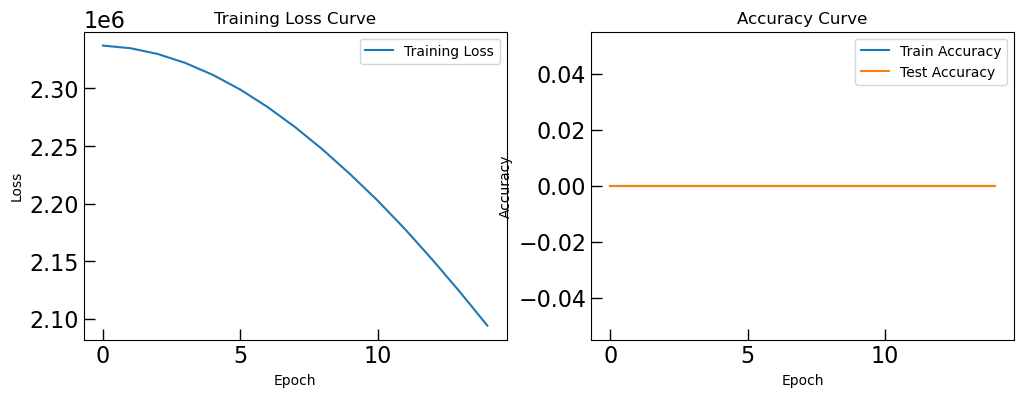

Model saved to ./model/cnn1.pth


In [8]:
if __name__ == "__main__":
    # 超参数
    input_height = 2
    input_width = 1000
    output_dim = 27
    num_samples = 3000
    batch_size = 32
    num_epochs = 15
    learning_rate = 0.001

    X, y = generate_data(num_samples, input_width)
    dataset = TensorDataset(X, y)
    train_size = int(0.8 * num_samples)
    test_size = num_samples - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 初始化模型、损失函数和优化器
    model = CNN1(input_height, input_width, output_dim)
    criterion = nn.MSELoss()  # 均方误差损失函数
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion,
                                                                  optimizer, num_epochs)

    # 绘制训练过程
    plot_training_curve(train_losses, train_accuracies, test_accuracies)

    # 保存模型
    torch.save(model.state_dict(), "./model/cnn1.pth")
    print("Model saved to ./model/cnn1.pth")

    # 加载模型并测试
    model.load_state_dict(torch.load("./model/cnn1.pth"))
    test_accuracy = calculate_accuracy(model, test_loader)